# TemplateFitter Example

## Imports

In [5]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import templatefitter as tf

## Read in Datasets

These samples contain $\Upsilon (4S) \rightarrow B\bar{B}$ events. The signal-side $B$ meson is reconstructed as $B\rightarrow\pi^0 \ell \nu_\ell$, $\ell = \mathrm{e}, \mu$. The tag-side was reconstructed using the FEI. These samples where used to constrain the $B\rightarrow\pi^0 \ell \nu_\ell$ in Moritz Gelb's [$B\rightarrow \ell \nu_\ell \gamma$ analysis](https://arxiv.org/abs/1810.12976).

In [6]:
path = pathlib.Path.cwd().parent / "datasets/b_to_pizlnu"
signal = pd.read_csv(path/"signal.csv")
remaining = pd.read_csv(path/"remaining.csv")
xulnu = pd.read_csv(path/"xulnu.csv")
data = pd.read_csv(path/"data.csv")

The dataframes only contain three columns. The missing mass squared, the event weight and a flag indicating the reconstruction channel.

In [7]:
signal.head()

,missingMass,weight,SignalChannel
0,1.110408,0.010533,1.0
1,0.205506,0.009799,1.0
2,1.268784,0.010267,1.0
3,0.152599,0.009911,1.0
4,0.034586,0.010133,1.0


## Define Templates

### General Template Settings

In [8]:
num_bins = 25
mm2_limits = (-1, 3)

### Prepare the Electron Channel

The electron channels is queried by requiring the SignalChannel flag to be equal to one.

In [9]:
e_sig = signal.query("SignalChannel==1.")
e_remaining = remaining.query("SignalChannel==1.")
e_xulnu = xulnu.query("SignalChannel==1.")
e_data = data.query("SignalChannel==1.")

The relative fractions of the different processes are needed to link the total yield to the different channels in the fit later

In [10]:
e_sig_frac = sum(e_sig.weight)/sum(signal.weight)
e_remaining_frac = sum(e_remaining.weight)/sum(remaining.weight)
e_xulnu_frac = sum(e_xulnu.weight)/sum(xulnu.weight)

Create one-dimensional histograms and construct the templates

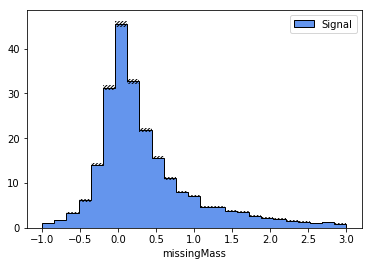

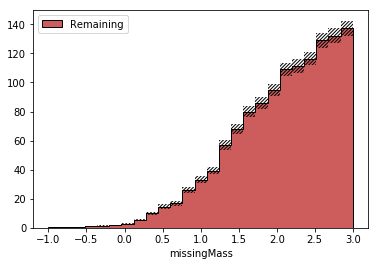

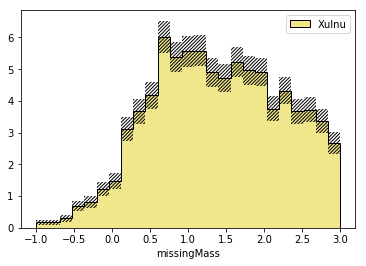

In [11]:
e_hsig = tf.histograms.Hist1d(bins=num_bins, range=mm2_limits, data=e_sig.missingMass, weights=e_sig.weight)
e_hremaining = tf.histograms.Hist1d(bins=num_bins, range=mm2_limits, data=e_remaining.missingMass,  weights=e_remaining.weight)
e_hxulnu = tf.histograms.Hist1d(bins=num_bins, range=mm2_limits, data=e_xulnu.missingMass,  weights=e_xulnu.weight)

e_tsig = tf.templates.Template1d("Signal", "missingMass", e_hsig, color="cornflowerblue")
e_tremaining = tf.templates.Template1d("Remaining", "missingMass", e_hremaining, color="indianred")
e_txulnu = tf.templates.Template1d("Xulnu", "missingMass", e_hxulnu, color="khaki")

for template in [e_tsig,e_tremaining, e_txulnu]:
    fig, axis = plt.subplots(1,1)
    template.plot_on(axis)
    axis.legend()

### Repeat everything for the Muon Channel

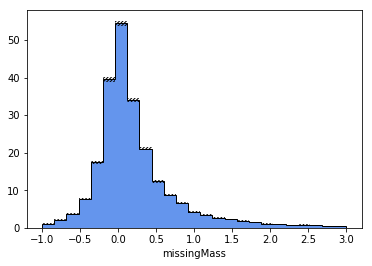

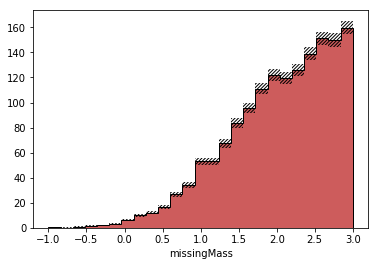

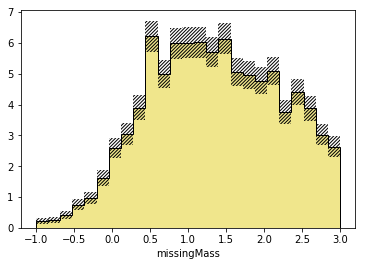

In [12]:
mu_sig = signal.query("SignalChannel==2.")
mu_remaining = remaining.query("SignalChannel==2.")
mu_xulnu = xulnu.query("SignalChannel==2.")
mu_data = data.query("SignalChannel==2.")

mu_sig_frac = sum(mu_sig.weight)/sum(signal.weight)
mu_remaining_frac = sum(mu_remaining.weight)/sum(remaining.weight)
mu_xulnu_frac = sum(mu_xulnu.weight)/sum(xulnu.weight)

mu_hsig = tf.histograms.Hist1d(bins=num_bins, range=mm2_limits, data=mu_sig.missingMass, weights=mu_sig.weight)
mu_hremaining = tf.histograms.Hist1d(bins=num_bins, range=mm2_limits, data=mu_remaining.missingMass, weights=mu_remaining.weight)
mu_hxulnu = tf.histograms.Hist1d(bins=num_bins, range=mm2_limits, data=mu_xulnu.missingMass, weights=mu_xulnu.weight)

mu_tsig = tf.templates.Template1d("Signal", "missingMass", mu_hsig, color="cornflowerblue")
mu_tremaining = tf.templates.Template1d("Remaining", "missingMass", mu_hremaining, color="indianred")
mu_txulnu = tf.templates.Template1d("Xulnu", "missingMass", mu_hxulnu, color="khaki")

for template in [mu_tsig, mu_tremaining, mu_txulnu]:
    fig, axis = plt.subplots(1,1)
    template.plot_on(axis)

## Define a MultiChannelTemplate

The total signal yield of the process $B\rightarrow\pi^0 \ell \nu_\ell$ can be extracted by fitting both channels simultaneously. The simultaneous fit increases the sensitivity.

In [13]:
mct = tf.templates.MultiChannelTemplate()

mct.define_channel("e", num_bins, mm2_limits)
mct.define_channel("mu", num_bins, mm2_limits)
mct.define_process("signal")
mct.define_process("remaining")
mct.define_process("xulnu")


mct.add_template("e", "xulnu", e_txulnu, e_xulnu_frac)
mct.add_template("e", "remaining", e_tremaining, e_remaining_frac)
mct.add_template("e", "signal", e_tsig, e_sig_frac)

mct.add_template("mu", "xulnu", mu_txulnu, mu_xulnu_frac)
mct.add_template("mu", "remaining", mu_tremaining,mu_remaining_frac)
mct.add_template("mu", "signal", mu_tsig, mu_sig_frac)


Add the data samples to the template

In [14]:
mct.add_data(e=tf.histograms.Hist1d(num_bins, mm2_limits, data=e_data.missingMass))
mct.add_data(mu=tf.histograms.Hist1d(num_bins, mm2_limits, data=mu_data.missingMass))

### Pre-Fit Distributions

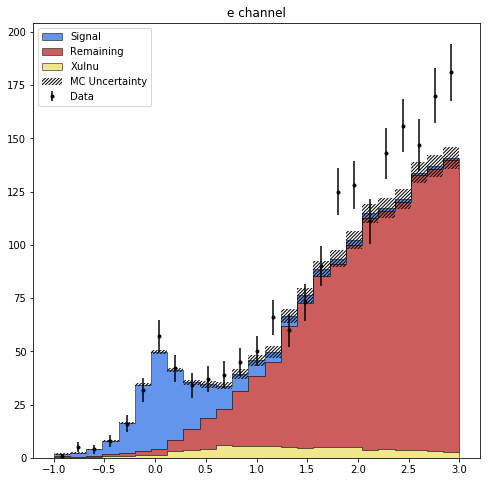

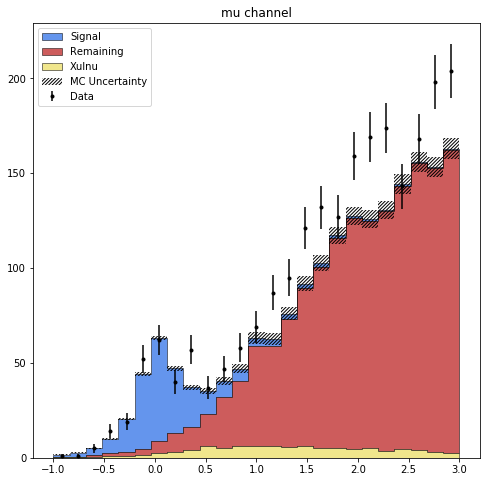

In [15]:
for channel in mct.channels.values():
    fig, axis = plt.subplots(1,1, figsize=(8,8))
    channel.plot_stacked_on(axis)
    axis.legend()
    axis.set_title(f"{channel._name} channel")

### Perform the Fit

In [16]:
fitter = tf.TemplateFitter(mct, "iminuit")
fitter.do_fit(update_templates=True)

FCN = 25.538282252747347 
 TOTAL NCALL = 6202 
 NCALLS = 6202 
 
 
 EDM = 3.8665250213310124e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,465.306,34.0208,,,,,No
1,remaining_yield,3394.75,95.8113,,,,,No
2,xulnu_yield,198.96,99.1931,,,,,No
3,e_xulnu_bin_0,-0.0408471,0.843344,,,,,No
4,e_xulnu_bin_1,0.100351,1.18322,,,,,No
5,e_xulnu_bin_2,-0.00278109,0.973668,,,,,No
6,e_xulnu_bin_3,0.000299334,0.844232,,,,,No
7,e_xulnu_bin_4,-0.0055504,0.974275,,,,,No
8,e_xulnu_bin_5,-0.0157879,0.974797,,,,,No
9,e_xulnu_bin_6,0.0404388,0.852052,,,,,No


FCN = 25.538233695371147 
 TOTAL NCALL = 7123 
 NCALLS = 921 
 
 
 EDM = 1.3762644940949487e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,465.38,34.4434,,,,,No
1,remaining_yield,3394.61,96.431,,,,,No
2,xulnu_yield,199.047,99.1774,,,,,No
3,e_xulnu_bin_0,-0.0406956,0.843388,,,,,No
4,e_xulnu_bin_1,0.100395,1.18322,,,,,No
5,e_xulnu_bin_2,-0.00292818,0.973517,,,,,No
6,e_xulnu_bin_3,0.000298248,0.844151,,,,,No
7,e_xulnu_bin_4,-0.0057477,0.973854,,,,,No
8,e_xulnu_bin_5,-0.015991,0.97417,,,,,No
9,e_xulnu_bin_6,0.040256,0.852136,,,,,No


MinimizeResult(fcn_min_val=25.538233695371147, params=<templatefitter.minimizer.Parameters object at 0x7fc69c4dea90>, succes=True)

### Post-Fit Distributions

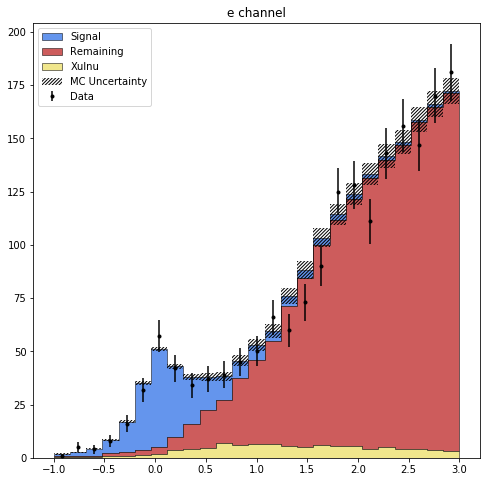

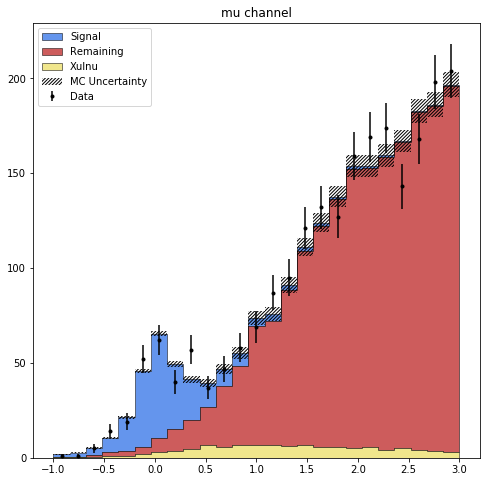

In [17]:
for channel in mct.channels.values():
    fig, axis = plt.subplots(1,1, figsize=(8,8))
    channel.plot_stacked_on(axis)
    axis.legend()
    axis.set_title(f"{channel._name} channel")

### Perform some Toy Studies

In [18]:
toy_study = tf.ToyStudy(mct, "iminuit")

#### Linearity Test

In [20]:
point, result, error = toy_study.do_linearity_test("signal", (400, 520), n_points=10)

Experiment Progress:   4%|▎         | 7/200 [00:00<00:02, 65.13it/s]

Performing linearity test for parameter: signal



Experiment Progress:  81%|████████  | 162/200 [00:02<00:00, 68.14it/s]


Experiment Progress:  76%|███████▋  | 153/200 [00:02<00:00, 68.49it/s]


Linearity Test Progress: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


Text(0.5, 0, 'Input Yield')

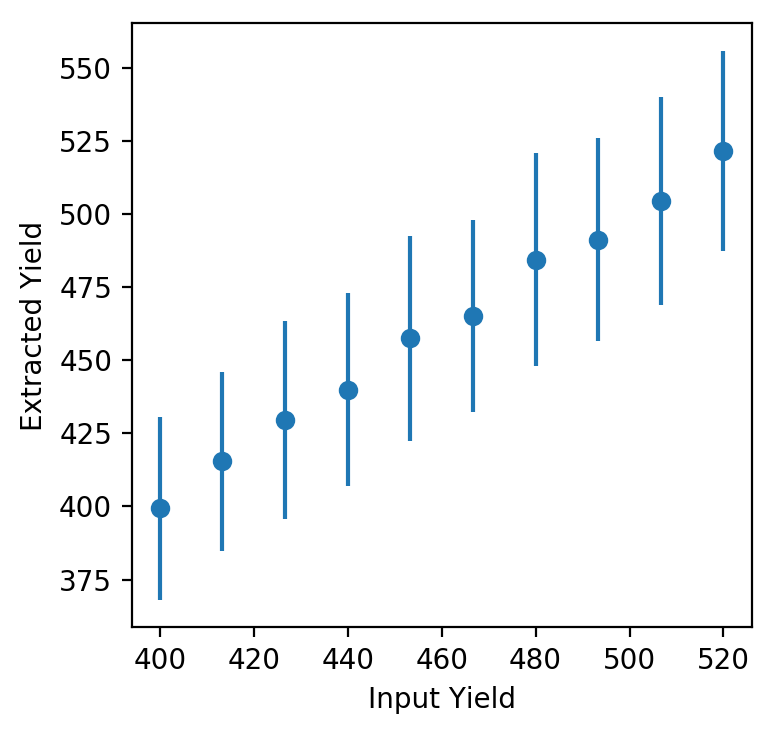

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.errorbar(point, result, yerr=error, ls="", marker="o")
ax.set_ylabel("Extracted Yield")
ax.set_xlabel("Input Yield")

#### Study Yield and Pull Distributions

In [22]:
mct.reset_parameters()
mct.add_data(e=tf.histograms.Hist1d(num_bins, mm2_limits, data=e_data.missingMass))
mct.add_data(mu=tf.histograms.Hist1d(num_bins, mm2_limits, data=mu_data.missingMass))
fitter.do_fit(update_templates=True)

FCN = 25.538282252747347 
 TOTAL NCALL = 6202 
 NCALLS = 6202 
 
 
 EDM = 3.8665250213310124e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,465.306,34.0208,,,,,No
1,remaining_yield,3394.75,95.8113,,,,,No
2,xulnu_yield,198.96,99.1931,,,,,No
3,e_xulnu_bin_0,-0.0408471,0.843344,,,,,No
4,e_xulnu_bin_1,0.100351,1.18322,,,,,No
5,e_xulnu_bin_2,-0.00278109,0.973668,,,,,No
6,e_xulnu_bin_3,0.000299334,0.844232,,,,,No
7,e_xulnu_bin_4,-0.0055504,0.974275,,,,,No
8,e_xulnu_bin_5,-0.0157879,0.974797,,,,,No
9,e_xulnu_bin_6,0.0404388,0.852052,,,,,No


FCN = 25.538233695371147 
 TOTAL NCALL = 7123 
 NCALLS = 921 
 
 
 EDM = 1.3762644940949487e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,465.38,34.4434,,,,,No
1,remaining_yield,3394.61,96.431,,,,,No
2,xulnu_yield,199.047,99.1774,,,,,No
3,e_xulnu_bin_0,-0.0406956,0.843388,,,,,No
4,e_xulnu_bin_1,0.100395,1.18322,,,,,No
5,e_xulnu_bin_2,-0.00292818,0.973517,,,,,No
6,e_xulnu_bin_3,0.000298248,0.844151,,,,,No
7,e_xulnu_bin_4,-0.0057477,0.973854,,,,,No
8,e_xulnu_bin_5,-0.015991,0.97417,,,,,No
9,e_xulnu_bin_6,0.040256,0.852136,,,,,No


MinimizeResult(fcn_min_val=25.538233695371147, params=<templatefitter.minimizer.Parameters object at 0x7fc69edf90b8>, succes=True)

In [23]:
toy_study = tf.ToyStudy(mct, "iminuit")
toy_study.do_experiments(n_exp=1000)

Experiments Progress:   1%|          | 8/1000 [00:00<00:13, 73.42it/s]

Performing toy study with 1000 experiments...


Experiments Progress: 100%|██████████| 1000/1000 [00:14<00:00, 70.55it/s]


Text(0.5, 0, 'Signal Yield')

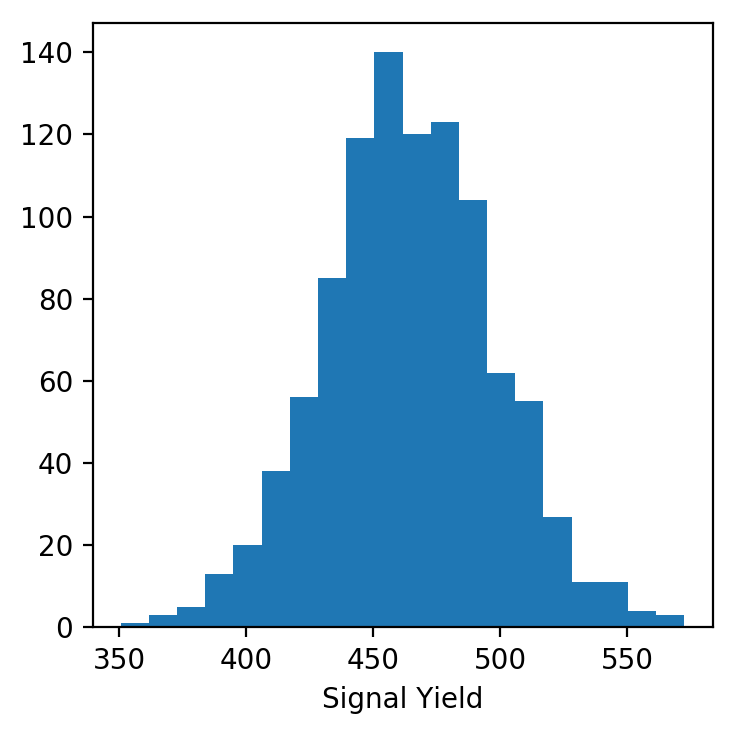

In [24]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.hist(toy_study.get_toy_results("signal")[0], bins=20)
ax.set_xlabel("Signal Yield")

Text(0.5, 0, 'Signal Pull')

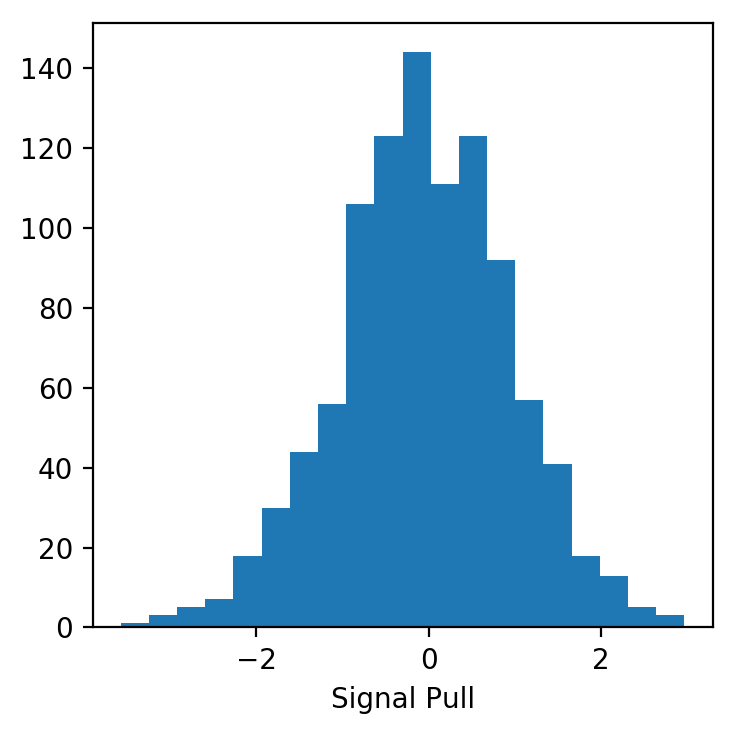

In [25]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.hist(toy_study.get_toy_result_pulls("signal"), bins=20)
ax.set_xlabel("Signal Pull")

### Significance of the observed Signal
(Based on Likelihood Ratio)

In [26]:
mct.reset_parameters()
mct.add_data(e=tf.histograms.Hist1d(num_bins, mm2_limits, data=e_data.missingMass))
mct.add_data(mu=tf.histograms.Hist1d(num_bins, mm2_limits, data=mu_data.missingMass))
fitter.get_significance("signal")

Perform nominal minimization:


FCN = 25.538282252747347 
 TOTAL NCALL = 6202 
 NCALLS = 6202 
 
 
 EDM = 3.8665250213310124e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,465.306,34.0208,,,,,No
1,remaining_yield,3394.75,95.8113,,,,,No
2,xulnu_yield,198.96,99.1931,,,,,No
3,e_xulnu_bin_0,-0.0408471,0.843344,,,,,No
4,e_xulnu_bin_1,0.100351,1.18322,,,,,No
5,e_xulnu_bin_2,-0.00278109,0.973668,,,,,No
6,e_xulnu_bin_3,0.000299334,0.844232,,,,,No
7,e_xulnu_bin_4,-0.0055504,0.974275,,,,,No
8,e_xulnu_bin_5,-0.0157879,0.974797,,,,,No
9,e_xulnu_bin_6,0.0404388,0.852052,,,,,No


FCN = 25.538233695371147 
 TOTAL NCALL = 7123 
 NCALLS = 921 
 
 
 EDM = 1.3762644940949487e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,465.38,34.4434,,,,,No
1,remaining_yield,3394.61,96.431,,,,,No
2,xulnu_yield,199.047,99.1774,,,,,No
3,e_xulnu_bin_0,-0.0406956,0.843388,,,,,No
4,e_xulnu_bin_1,0.100395,1.18322,,,,,No
5,e_xulnu_bin_2,-0.00292818,0.973517,,,,,No
6,e_xulnu_bin_3,0.000298248,0.844151,,,,,No
7,e_xulnu_bin_4,-0.0057477,0.973854,,,,,No
8,e_xulnu_bin_5,-0.015991,0.97417,,,,,No
9,e_xulnu_bin_6,0.040256,0.852136,,,,,No


Background


FCN = 137.53621752352822 
 TOTAL NCALL = 5888 
 NCALLS = 5888 
 
 
 EDM = 1.4056896521830419e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,0,0,,,,,Yes
1,remaining_yield,2582.76,80.3006,,,,,No
2,xulnu_yield,1476.38,75.2233,,,,,No
3,e_xulnu_bin_0,-0.285611,0.993329,,,,,No
4,e_xulnu_bin_1,0.774874,0.950774,,,,,No
5,e_xulnu_bin_2,0.288961,0.941816,,,,,No
6,e_xulnu_bin_3,0.221951,0.964884,,,,,No
7,e_xulnu_bin_4,1.0203,0.939182,,,,,No
8,e_xulnu_bin_5,1.98974,0.898856,,,,,No
9,e_xulnu_bin_6,3.32418,0.888856,,,,,No


FCN = 137.53620222855136 
 TOTAL NCALL = 6575 
 NCALLS = 687 
 
 
 EDM = 6.27442520716662e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,0,0,,,,,Yes
1,remaining_yield,2582.66,80.2599,,,,,No
2,xulnu_yield,1476.35,75.3204,,,,,No
3,e_xulnu_bin_0,-0.285508,0.99334,,,,,No
4,e_xulnu_bin_1,0.775442,0.949495,,,,,No
5,e_xulnu_bin_2,0.288722,0.941458,,,,,No
6,e_xulnu_bin_3,0.221576,0.964836,,,,,No
7,e_xulnu_bin_4,1.02021,0.938997,,,,,No
8,e_xulnu_bin_5,1.98913,0.897564,,,,,No
9,e_xulnu_bin_6,3.32378,0.887355,,,,,No


14.966493813393985

### Profile Likelihood Scan

In [27]:
sig_yield, nll_profile, hesse = fitter.profile("signal_yield", num_cpu=3)


Calculating profile likelihood for parameter: 'signal_yield'
Start nominal minimization


FCN = 25.538225207416723 
 TOTAL NCALL = 19503 
 NCALLS = 19503 
 
 
 EDM = 6.987300822134732e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,465.377,34.8924,,,,,No
1,remaining_yield,3394.73,97.762,,,,,No
2,xulnu_yield,198.979,98.8119,,,,,No
3,e_xulnu_bin_0,-0.0406393,0.998931,,,,,No
4,e_xulnu_bin_1,0.10019,0.997666,,,,,No
5,e_xulnu_bin_2,-0.0028239,0.998209,,,,,No
6,e_xulnu_bin_3,-3.41335e-05,0.997914,,,,,No
7,e_xulnu_bin_4,-0.00571781,0.998882,,,,,No
8,e_xulnu_bin_5,-0.0163449,0.999263,,,,,No
9,e_xulnu_bin_6,0.0393667,0.999617,,,,,No


FCN = 25.538218219913993 
 TOTAL NCALL = 20423 
 NCALLS = 920 
 
 
 EDM = 1.3020099664377228e-13 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,signal_yield,465.39,34.8921,,,,,No
1,remaining_yield,3394.59,97.766,,,,,No
2,xulnu_yield,199.025,98.8135,,,,,No
3,e_xulnu_bin_0,-0.0407089,0.998931,,,,,No
4,e_xulnu_bin_1,0.100438,0.997667,,,,,No
5,e_xulnu_bin_2,-0.00280887,0.998209,,,,,No
6,e_xulnu_bin_3,0.000125679,0.997914,,,,,No
7,e_xulnu_bin_4,-0.00553848,0.998882,,,,,No
8,e_xulnu_bin_5,-0.0157293,0.999262,,,,,No
9,e_xulnu_bin_6,0.0398338,0.999617,,,,,No


Start profiling the likelihood using 3 processes...


Profile Progess: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


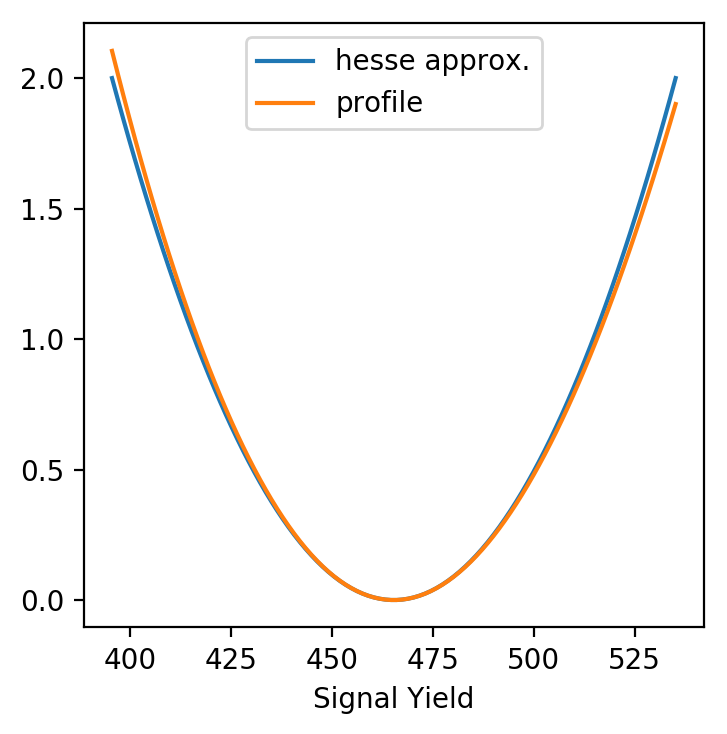

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.plot(sig_yield, hesse, label="hesse approx.")
ax.plot(sig_yield, nll_profile, label="profile")
ax.legend()
ax.set_xlabel("Signal Yield")
plt.show()